Benchmarking xarray netcdf vs xarray zarr using Dask Local cluster.
Here we experiment with chunk size 878/ chunk shape time:40. 

For general info on GFDL specific Python/Jupyter/Anaconda, please checkout http://wiki.gfdl.noaa.gov/Python. It also has information on port for
Data citation

Zhao, Ming; Blanton, Chris; John, Jasmin G; Radhakrishnan, Aparna; Zadeh, Niki T.; McHugh, Colleen; Rand, Kristopher; Vahlenkamp, Hans; Wilson, Chandin; Ginoux, Paul; Malyshev, Sergey; Wyman, Bruce; Guo, Huan; Balaji, V; Held, Isaac M; Dunne, John P.; Winton, Michael; Adcroft, Alistair; Milly, P.C.D; Shevliakova, Elena; Knutson, Thomas; Ploshay, Jeffrey; Zeng, Yujin (2018). NOAA-GFDL GFDL-CM4C192 model output prepared for CMIP6 HighResMIP. Version 20180701 [1].Earth System Grid Federation. https://doi.org/10.22033/ESGF/CMIP6.2262




User input: Dask analysis template

In [51]:
import os 
clusterType = "SLURM" #or SLURM or Local
platform = "PPAN"
numCores = 6
numWorkers = 6
mem='48GB'
varname='tas'
dashPort = ':1984'
if (platform == "PPAN"):
    logdir = '/work/a1r/dask/logs/'
    localdir = '' #We will set local directory when we define the cluster
else:
    logdir = '/local2/home/a1r/logs/'
    localdir = logdir
print("Logs:", logdir)

res_nc = {} #settings, time
res_zarr = {} #settings, time

Logs: /work/a1r/dask/logs/


In [52]:
# get the plot in notebook
%matplotlib inline
import xarray as xr 

Use dask.distributed task scheduler and launch DASK using SLURMcluster

In [53]:
from dask.distributed import Client

#Instantiate Dask client
if (clusterType == "local"):
    from dask.distributed import LocalCluster
    cluster = LocalCluster(dashboard_address=dashPort,local_directory=localdir)
else:
    from dask_jobqueue import SLURMCluster
    scheduler_options = {}
    scheduler_options["dashboard_address"] = dashPort
    cluster = SLURMCluster(queue='batch',memory=mem,project='gfdl_f',cores=numCores,walltime='2:60:00',
                           scheduler_options=scheduler_options,log_directory=logdir,
                           local_directory=(os.getenv('TMPDIR'))) 
    
cluster.scale(numWorkers)
client = Client(cluster)    
client

Client Scheduler: tcp://140.208.147.176:36306 Dashboard: http://140.208.147.176:1984/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


CPU times: user 359 ms, sys: 30 ms, total: 389 ms
Wall time: 747 ms
43.5 s ± 1.11 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


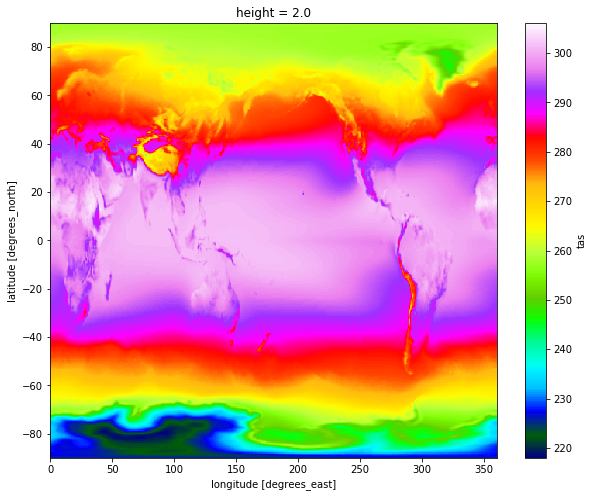

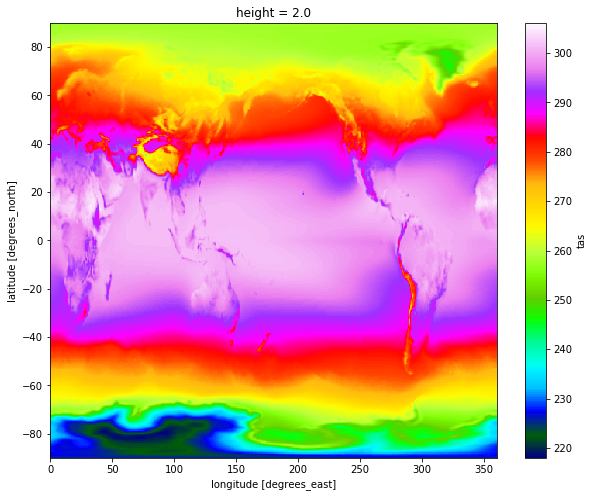

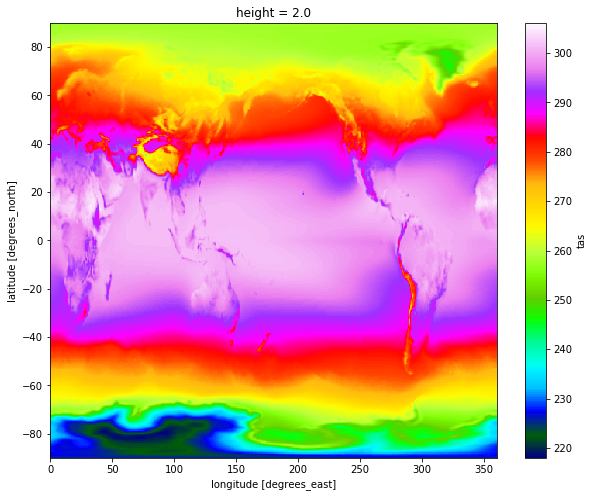

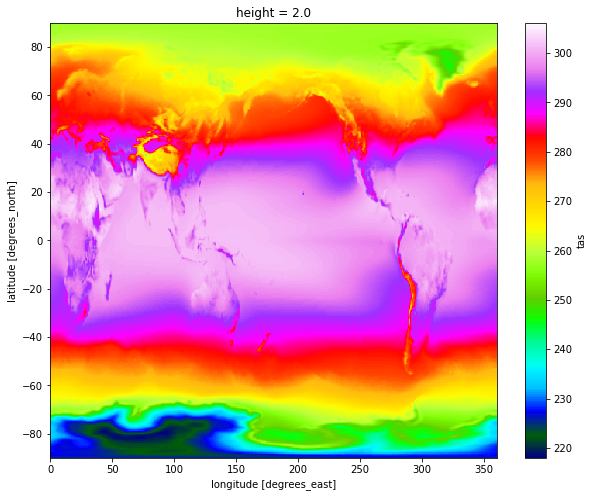

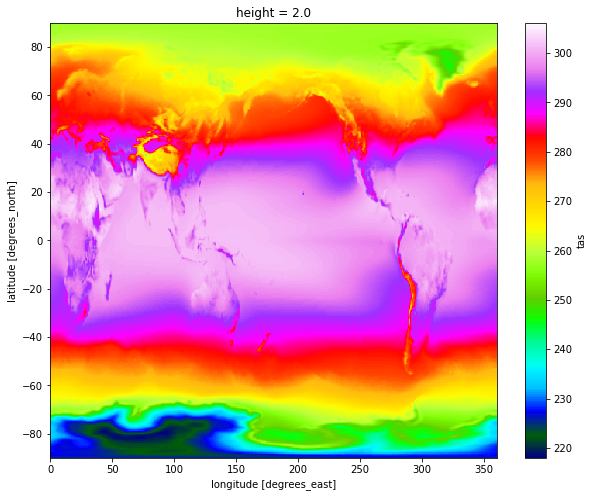

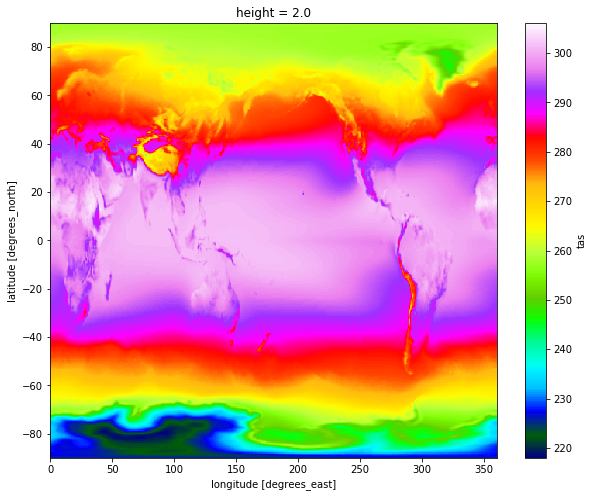

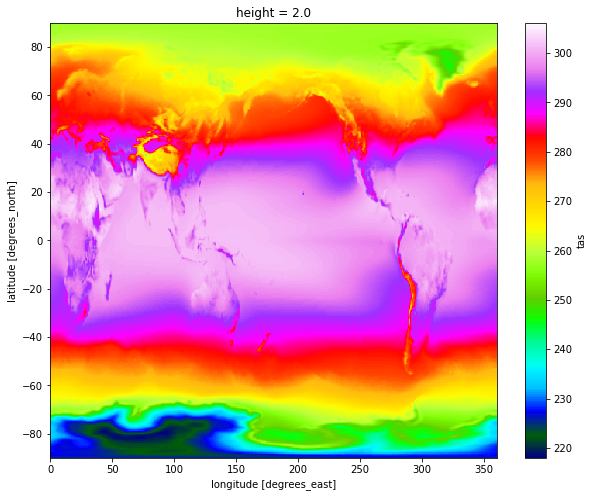

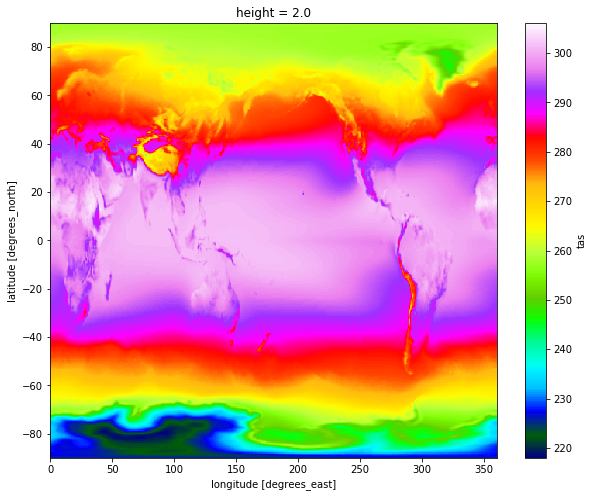

In [61]:
datadir = "/work/a1r/enes20/out2/tas_3hr_2015-2051_40.zarr"
%time ds4 = xr.open_zarr(datadir) 
temp_mean = ds4[varname].mean(dim=['time'])
%timeit temp_mean.plot(figsize=[10, 8],cmap='gist_ncar') 

In [62]:
ds4['tas'].data

,Array,Chunk
Bytes,87.25 GB,33.18 MB
Shape,"(105192, 360, 576)","(40, 360, 576)"
Count,2631 Tasks,2630 Chunks
Type,float32,numpy.ndarray


In [66]:
datadir = '/work/a1r/enes20/CMIP6/HighResMIP/NOAA-GFDL/GFDL-CM4C192/highresSST-future/r1i1p1f1/3hr/'+varname+'/gr3/v20180701/'
%time ds5 = xr.open_mfdataset(datadir+"*.nc", chunks={'time': 40}, combine='by_coords',parallel=True,decode_cf=False)

CPU times: user 22 s, sys: 1.2 s, total: 23.2 s
Wall time: 5min 41s


In [67]:
ds5['tas'].data

,Array,Chunk
Bytes,87.25 GB,33.18 MB
Shape,"(105192, 360, 576)","(40, 360, 576)"
Count,5262 Tasks,2630 Chunks
Type,float32,numpy.ndarray


1min 16s ± 826 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


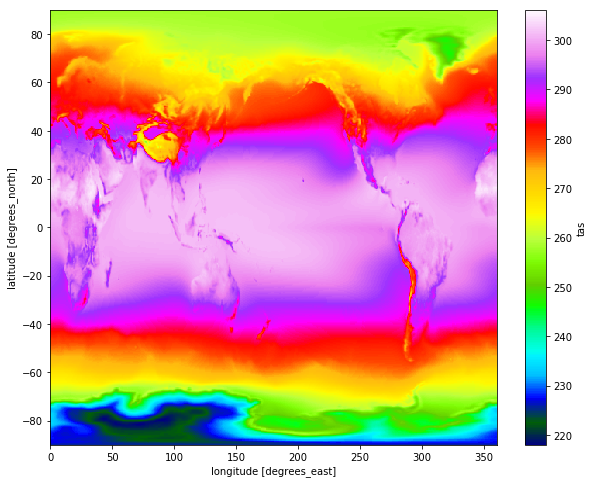

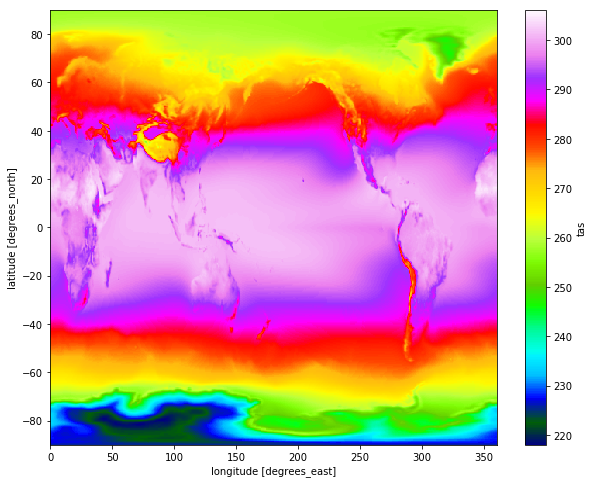

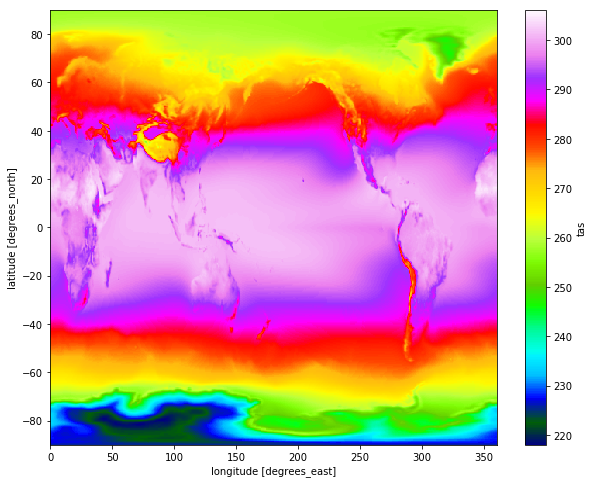

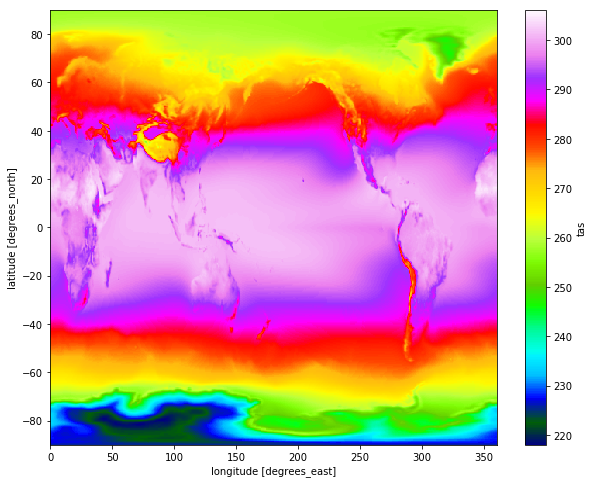

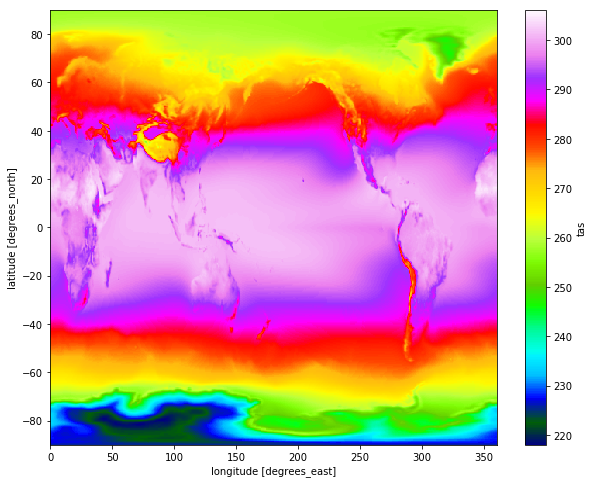

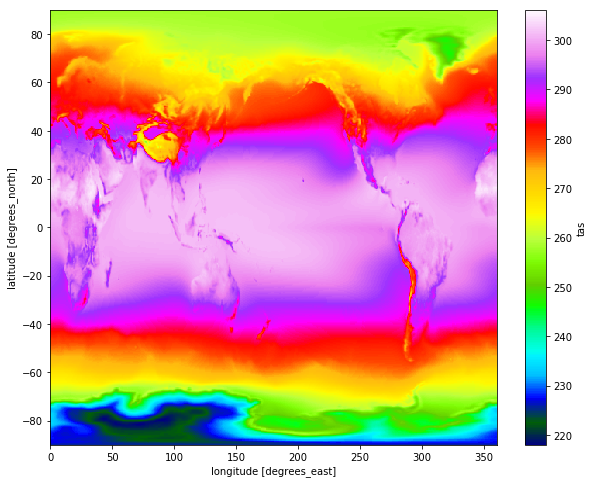

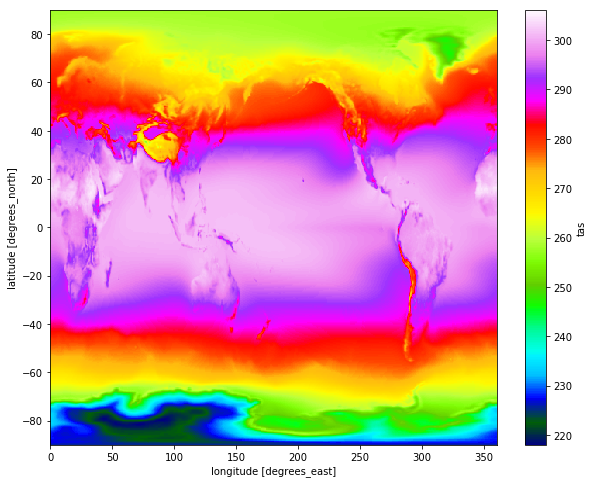

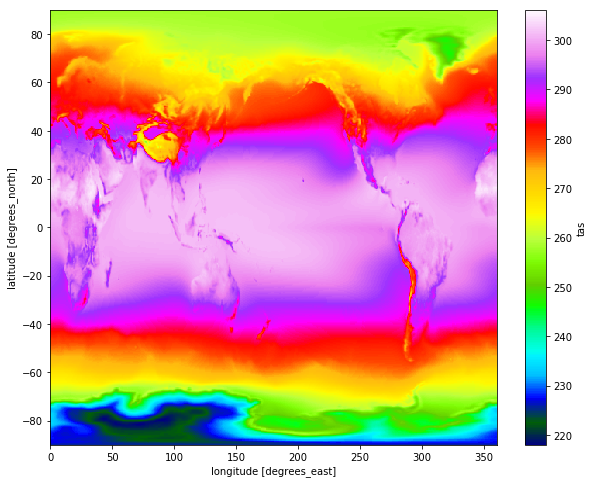

In [68]:
temp_mean5 = ds5[varname].mean(dim=['time'])
%timeit temp_mean5.plot(figsize=[10, 8],cmap='gist_ncar') 

In [ ]:
client.close()
cluster.close()

In [ ]:
#If we use chunks time:240 
#Open takes 1.46s
#Time ave plot takes 46.1seconds
#Plot a specific region takes 46s